This is the lab done in class where we cluster bank customers. 

## Phase 1 : Import Dependencies

In [59]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Phase 2 : Data Preparation

Here, we read the data using pandas.

In [60]:
df = pd.read_csv('/Users/satkarkarki/Desktop/usd/past/Learning/clustering-lab/data/BankSegment.csv')

In [61]:
df.head()

,age,job,marital,Married,education,Ed,default,Def,balance,housing,...,Personal,contact,day,month,duration,campaign,pdays,previous,Previous,Subscribe
0,30,unemployed,married,1,primary,1,no,0,1787,no,...,0,cellular,19,oct,79,1,-1,0,0,0
1,33,services,married,1,secondary,2,no,0,4789,yes,...,1,cellular,11,may,220,1,339,4,0,0
2,35,management,single,0,tertiary,3,no,0,1350,yes,...,0,cellular,16,apr,185,1,330,1,0,0
3,30,management,married,1,tertiary,3,no,0,1476,yes,...,1,unknown,3,jun,199,4,-1,0,0,0
4,59,blue-collar,married,1,secondary,2,no,0,0,yes,...,0,unknown,5,may,226,1,-1,0,0,0


This code selects all the categorical columns from the dataframe and stores them in `categorical_cols`.

In [62]:
categorical_cols = df.select_dtypes(include=['object']).columns
categorical_cols

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month'],
      dtype='object')

Clustering algorithms (like KMeans) require numeric data. This step converts categorical text into numeric binary features so you can cluster the data. We usethe `OneHotEncoder` to convert categorical text columns into numeric binary columns.

In [63]:
# handle_unknown='ignore' is used to ignore the categorical columns that are not present in the data. 
# sparse_output=False is used to return a dense array.
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) 
# fit_transform() is used to fit the encoder on the categorical columns and transform the data.
encoded_categorical_data = encoder.fit_transform(df[categorical_cols])
encoded_categorical_data

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

Next, we convert the `NumPy` array from the encoder into a DataFrame. The output shows binary values (0.0 and 1.0) instead of text. Well, the data is hella sparse tho!

In [64]:
# encoder.get_feature_names_out is used to get the feature names of the encoded categorical columns (e.g. job_admin, job_blue-collar, etc.)
encoded_categorical_df = pd.DataFrame(encoded_categorical_data, columns=encoder.get_feature_names_out(categorical_cols))
encoded_categorical_df.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In this step, we remove all original categorical (text) columns from the original DataFrame. This ensures that we have a clean dataset with only numeric features i.e. we are ready for clustering.

In [65]:
df_encoded = df.drop(columns=categorical_cols)
df_encoded.head()

,age,Married,Ed,Def,balance,House,Personal,day,duration,campaign,pdays,previous,Previous,Subscribe
0,30,1,1,0,1787,0,0,19,79,1,-1,0,0,0
1,33,1,2,0,4789,1,1,11,220,1,339,4,0,0
2,35,0,3,0,1350,1,0,16,185,1,330,1,0,0
3,30,1,3,0,1476,1,1,3,199,4,-1,0,0,0
4,59,1,2,0,0,1,0,5,226,1,-1,0,0,0


In this step of data prep, we create tbeh complete feature set needed for clustering (original numeric + encoded binary variables).

In [72]:
df_encoded = pd.concat([df_encoded, encoded_categorical_df], axis=1)
df_encoded.head()

,age,Married,Ed,Def,balance,House,Personal,day,duration,campaign,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,30,1,1,0,1787,0,0,19,79,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,33,1,2,0,4789,1,1,11,220,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,35,0,3,0,1350,1,0,16,185,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,30,1,3,0,1476,1,1,3,199,4,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,59,1,2,0,0,1,0,5,226,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [73]:
df_encoded.shape

(4521, 134)

The final step is to convert the prepared DataFrame into the NumPy array format that scikit-learn clustering algorithms expect. It's the final data preparation step before running clustering.

In [74]:
datalist = df_encoded.values
datalist

array([[30.,  1.,  1., ...,  0.,  1.,  0.],
       [33.,  1.,  2., ...,  0.,  0.,  0.],
       [35.,  0.,  3., ...,  0.,  0.,  0.],
       ...,
       [57.,  1.,  2., ...,  0.,  0.,  0.],
       [28.,  1.,  2., ...,  0.,  0.,  0.],
       [44.,  0.,  3., ...,  0.,  0.,  0.]])

In [75]:
datalist.shape[1]

134

## Phase 3 : Setup K-Means

Before initializing k-means algorithm, we define a list of values i.e. **K** (number of clusters) to try.

In [76]:
K = [2, 3, 4, 6, 10]

**t-SNE:** t-SNE (t-Distributed Stochastic Neighbor Embedding) is a dimensionality reduction technique that maps high-dimensional data to 2D or 3D for visualization while preserving local structure.

**Why it matters for clustering:**
- We have many features (40+ columns) i.e. **high-dimensionality**; so we can't visualize clusters directly.
- t-SNE creates a 2D plot where similar points are close together, making clusters visible.

**The algorithm flow:**
- Compute pairwise similarities in high dimensions using Gaussian probabilities.
- Initiate 2D coordinates (`n_components=2`) and compute similarities using the t-distribution.
- `init='pca'` starts the 2D embedding from the Principal Component Analysis coordinates.
- `random_state` ensures the same result is obtained each run


In [77]:
tsne = TSNE(n_components=2, init='pca', random_state=0)
embed = tsne.fit_transform(datalist)

Next, we will initialize an empty dictionary to store the cluster labels for each value of K in `result`.
Another, empty dictionary is also initialized to store the KMeans models for each value of K.

In [78]:
result = {}
kmeans_models = {}

#### K-Means Clustering Loop Explanation

**Overview**
This code performs K-Means clustering on the bank customer data for multiple values of K (number of clusters) to identify the optimal number of customer segments.

**Objective Function**
K-Means minimizes the **Within-Cluster Sum of Squares (WCSS)**:

**Algorithm Steps**
1. **Initialize**: Randomly place K centroids
2. **Assign**: Each point → nearest centroid
3. **Update**: Recalculate centroids as cluster means
4. **Repeat** steps 2-3 until convergence

**Parameters:**
1. `n_clusters=k`: Number of clusters for this iteration.
2. `random_state=0`: Ensures reproducibility
3. `n_init=10`: Runs K-Means 10 times with different initialization (returns result with the lowerst WCSS)


In [79]:
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(datalist)

    result.update({f'k={k}_cluster_label': kmeans.labels_})
    kmeans_models[k] = kmeans

In [80]:
kmeans_models

{2: KMeans(n_clusters=2, n_init=10, random_state=0),
 3: KMeans(n_clusters=3, n_init=10, random_state=0),
 4: KMeans(n_clusters=4, n_init=10, random_state=0),
 6: KMeans(n_clusters=6, n_init=10, random_state=0),
 10: KMeans(n_clusters=10, n_init=10, random_state=0)}

## Phase 4: Evaluate Models

Silhouette Score measures clustering quality: how well-separated clusters are and how well points fit their assigned clusters. Range: -1 to +1. 

- +1: point is well-matched to its cluster and far from others
- 0: point is on the boundary between clusters
- -1: point is closer to another cluster than its own

In [81]:
silhouette_avg_k2 = silhouette_score(datalist, result['k=2_cluster_label'])
print(f"Silhouette Score for k=2: {silhouette_avg_k2}") # Print the calculated score

Silhouette Score for k=2: 0.8323020606024569


In [82]:
silhouette_avg_k3 = silhouette_score(datalist, result['k=3_cluster_label'])
print(f"Silhouette Score for k=3: {silhouette_avg_k3}") # Print the calculated score

Silhouette Score for k=3: 0.7458978400256704


In [83]:
silhouette_avg_k4 = silhouette_score(datalist, result['k=4_cluster_label'])
print(f"Silhouette Score for k=4: {silhouette_avg_k4}") # Print the calculated score

Silhouette Score for k=4: 0.7080689698474605


In [84]:
silhouette_avg_k6 = silhouette_score(datalist, result['k=6_cluster_label'])
print(f"Silhouette Score for k=6: {silhouette_avg_k6}") # Print the calculated score

Silhouette Score for k=6: 0.6497794865626993


The data suggests that the best number of clusters is **2** i.e. two primary customer segments. Adding more clusters reduces separation and cohesion.

If business needs require more granularity, **K=3** is also strong (0.7459).

## Phase 5: Save the Results

This saves clustering results for comparision, integration with customer data, and business use (targeting, analysis, reporting). It serves as the bridge between clustering analysis and actionable business insights.

In [85]:
# Output the result of different parameter K to csv file

# Convert the 'result' dictionary (containing cluster labels for different K) into a pandas DataFrame
cluster_labels_df = pd.DataFrame(result)

# Save the DataFrame to a CSV file in Google Drive
cluster_labels_df.to_csv('/Users/satkarkarki/Desktop/usd/past/Learning/clustering-lab/data/BankSegment_result.csv', index=False, header=True)

## Phase 6: Visualize Results

Before we visualize the clusters, we need to prepare the data and gather diagnostic information about each clustering solution. This section:

1. **Creates a 2D embedding** using t-SNE that will serve as the canvas for all our visualizations
2. **Re-runs K-Means clustering** with detailed diagnostic output to understand cluster characteristics
3. **Stores cluster labels and models** that will be used to color-code the visualizations

**Why we print diagnostics here:**
- **Cluster centers** show the "average customer profile" for each segment - this helps us understand what makes each cluster unique
- **Sample counts** reveal cluster sizes - showing whether segments are balanced or if some clusters are much larger than others
- This diagnostic information provides context for interpreting the visualizations we'll create next

The visualizations will use the t-SNE embedding and cluster labels to show how well-separated the clusters are in 2D space, helping us validate the clustering results visually.

In [86]:
# Set parameter K for the K-Means Algorithm and perform clustering and t-SNE embedding

# Define a list of values for K (number of clusters) to try
K = [2, 3, 4, 6, 10]

# Initialize t-SNE for dimensionality reduction to 2 components for visualization
tsne = TSNE(n_components=2, init='pca', random_state=0)
# Fit and transform the processed data (datalist) using t-SNE to get a 2D embedding
embed = tsne.fit_transform(datalist)

# Initialize an empty dictionary to store the cluster labels for each value of K
result = {}
# Initialize a dictionary to store the trained KMeans models for each value of K
kmeans_models = {}

# Loop through each value of K defined in the list
for k in K:
  print(f"When k is: {k}") # Print the current value of K being processed

  # K-Means Algorithm: Initialize and train the KMeans model
  kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(datalist) # Added n_init=10
  # Store the trained KMeans model in the dictionary with K as the key
  kmeans_models[k] = kmeans

  # Print the coordinates of the cluster centers for the current K
  print("cluster_centers")
  print(kmeans.cluster_centers_)

  # Calculate and print the sample counts for each cluster
  print("sample counts of each cluster:")
  print(np.bincount(kmeans.labels_)) # np.bincount counts the occurrences of each label (cluster)

  # Record the cluster labels for each sample for the current K
  result.update({f'k={k}_cluster_label': kmeans.labels_})

When k is: 2
cluster_centers
[[4.10467986e+01 6.18859139e-01 2.05960419e+00 1.76949942e-02
  9.00861234e+02 5.70663562e-01 1.57625146e-01 1.59010477e+01
  2.65432363e+02 2.79324796e+00 3.94577416e+01 5.32246799e-01
  2.77066356e-02 1.16647264e-01 1.08498254e-01 2.13504075e-01
  3.67869616e-02 2.35157159e-02 2.08149010e-01 4.93597206e-02
  4.07450524e-02 9.42956927e-02 1.79278231e-02 1.69965076e-01
  2.91036088e-02 8.14901048e-03 1.18277066e-01 6.18859139e-01
  2.62863795e-01 1.50407451e-01 5.17345751e-01 2.91501746e-01
  4.07450524e-02 9.82305006e-01 1.76949942e-02 4.29336438e-01
  5.70663562e-01 8.42374854e-01 1.57625146e-01 6.39580908e-01
  6.49592549e-02 2.95459837e-01 6.49592549e-02 1.38766007e-01
  3.72526193e-03 4.95925495e-02 3.35273574e-02 1.61583236e-01
  1.15483120e-01 1.02444703e-02 3.14551804e-01 7.84633295e-02
  1.74621653e-02 1.16414435e-02 1.08498254e-01 2.13504075e-01
  3.67869616e-02 2.35157159e-02 2.08149010e-01 4.93597206e-02
  4.07450524e-02 9.42956927e-02 1.7927823

In [87]:
# Get column names from the encoded dataframe
feature_names = df_encoded.columns.tolist()

# Create dataframes for cluster centers for k=4, k=6 and k=10
cluster_centers_k2 = pd.DataFrame(kmeans_models[2].cluster_centers_, columns=feature_names)
cluster_centers_k3 = pd.DataFrame(kmeans_models[3].cluster_centers_, columns=feature_names)
cluster_centers_k4 = pd.DataFrame(kmeans_models[4].cluster_centers_, columns=feature_names)
cluster_centers_k6 = pd.DataFrame(kmeans_models[6].cluster_centers_, columns=feature_names)
cluster_centers_k10 = pd.DataFrame(kmeans_models[10].cluster_centers_, columns=feature_names)

In [88]:
print("Cluster Centers for k=2:")
display(cluster_centers_k2)

Cluster Centers for k=2:


,age,Married,Ed,Def,balance,House,Personal,day,duration,campaign,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,41.046799,0.618859,2.059604,0.017695,900.861234,0.570664,0.157625,15.901048,265.432363,2.793248,...,0.003725,0.049593,0.033527,0.161583,0.115483,0.010244,0.314552,0.078463,0.017462,0.011641
1,43.513274,0.615044,2.185841,0.000000,11339.101770,0.477876,0.061947,16.185841,236.004425,2.800885,...,0.017699,0.039823,0.017699,0.053097,0.154867,0.022124,0.207965,0.230088,0.022124,0.008850


In [89]:
print("Cluster Centers for k=3:")
display(cluster_centers_k3)

Cluster Centers for k=3:


,age,Married,Ed,Def,balance,House,Personal,day,duration,campaign,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,40.844983,0.616198,2.059582,0.019603,550.585762,0.575961,0.161723,15.872582,263.732525,2.797008,...,0.003611,0.050297,0.035337,0.168945,0.111942,9.543461e-03,0.320609,0.070157,0.015476,0.011865
1,42.935652,0.627826,2.076522,0.000000,5258.587826,0.511304,0.100870,16.257391,272.883478,2.742609,...,0.006957,0.045217,0.017391,0.081739,0.142609,2.086957e-02,0.248696,0.180870,0.027826,0.006957
2,44.724638,0.681159,2.333333,0.000000,18456.913043,0.463768,0.086957,15.463768,202.463768,3.028986,...,0.028986,0.014493,0.014493,0.057971,0.217391,1.734723e-18,0.173913,0.188406,0.057971,0.028986


In [90]:
print("Cluster Centers for k=4:")
display(cluster_centers_k4)

Cluster Centers for k=4:


,age,Married,Ed,Def,balance,House,Personal,day,duration,campaign,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,40.750340,0.615029,2.057446,2.069153e-02,442.446501,0.578818,0.164443,15.849170,263.104274,2.798530,...,0.003267,0.050095,3.566567e-02,0.172339,0.110264,9.801252e-03,0.325347,0.066431,0.016063,0.010346
1,43.380000,0.633333,2.186667,-3.469447e-18,10670.013333,0.500000,0.046667,16.233333,236.140000,2.940000,...,0.026667,0.033333,1.333333e-02,0.046667,0.160000,1.333333e-02,0.220000,0.226667,0.020000,0.013333
2,42.782222,0.632593,2.080000,0.000000e+00,3851.989630,0.512593,0.114074,16.318519,277.914074,2.751111,...,0.005926,0.047407,2.222222e-02,0.094815,0.142222,1.629630e-02,0.245926,0.160000,0.025185,0.017778
3,46.478261,0.695652,2.217391,0.000000e+00,26353.695652,0.521739,0.130435,12.565217,172.782609,2.304348,...,0.000000,0.043478,6.938894e-18,0.086957,0.260870,1.734723e-18,0.173913,0.130435,0.043478,0.000000


In [91]:
print("Cluster Centers for k=6:")
display(cluster_centers_k6)

Cluster Centers for k=6:


,age,Married,Ed,Def,balance,House,Personal,day,duration,campaign,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,40.627572,0.614345,2.054380,0.02234,335.775720,0.580247,0.167549,15.860082,263.128748,2.823339,...,0.003233,4.791299e-02,0.036449,0.177837,0.105232,8.818342e-03,0.331276,0.060553,0.014991,1.058201e-02
1,43.171429,0.600000,2.242857,0.00000,13280.242857,0.442857,0.042857,16.800000,213.385714,2.885714,...,0.042857,6.938894e-18,0.014286,0.042857,0.185714,1.734723e-18,0.242857,0.200000,0.042857,2.857143e-02
2,42.583443,0.632063,2.086728,0.00000,2673.219448,0.530880,0.118265,16.101183,277.660972,2.633377,...,0.006570,5.781866e-02,0.023653,0.102497,0.156373,1.182654e-02,0.245729,0.141919,0.027595,1.576873e-02
3,60.000000,1.000000,1.000000,0.00000,71188.000000,0.000000,0.000000,6.000000,205.000000,1.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000e+00
4,43.086792,0.633962,2.094340,0.00000,6488.509434,0.520755,0.094340,16.147170,256.581132,2.890566,...,0.003774,5.283019e-02,0.018868,0.067925,0.132075,3.773585e-02,0.237736,0.218868,0.015094,7.547170e-03
5,45.863636,0.681818,2.272727,0.00000,24315.772727,0.545455,0.136364,12.863636,171.318182,2.363636,...,0.000000,4.545455e-02,0.000000,0.090909,0.272727,0.000000e+00,0.181818,0.136364,0.000000,-1.734723e-18


In [92]:
print("\nCluster Centers for k=10:")
display(cluster_centers_k10)


Cluster Centers for k=10:


,age,Married,Ed,Def,balance,House,Personal,day,duration,campaign,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,43.511811,0.614173,2.157480,0.000000e+00,7764.779528,0.472441,0.047244,16.330709,257.094488,2.795276,...,7.874016e-03,6.299213e-02,2.362205e-02,0.055118,0.125984,3.937008e-02,0.181102,0.251969,7.874016e-03,1.734723e-18
1,41.268642,0.614723,2.092734,1.912046e-03,1082.537285,0.596558,0.120459,15.603250,293.808795,2.537285,...,8.604207e-03,6.596558e-02,3.824092e-02,0.120459,0.137667,1.147228e-02,0.295411,0.078394,1.720841e-02,1.147228e-02
2,45.500000,0.666667,2.166667,0.000000e+00,24154.444444,0.555556,0.111111,12.833333,160.611111,2.555556,...,-8.673617e-19,5.555556e-02,6.938894e-18,0.111111,0.333333,1.734723e-18,0.222222,0.055556,-3.469447e-18,0.000000e+00
3,42.404814,0.628009,2.080963,0.000000e+00,2655.547046,0.522976,0.122538,16.035011,283.437637,2.730853,...,4.376368e-03,5.470460e-02,2.188184e-02,0.111597,0.155361,8.752735e-03,0.234136,0.148796,1.969365e-02,2.188184e-02
4,60.000000,1.000000,1.000000,0.000000e+00,71188.000000,0.000000,0.000000,6.000000,205.000000,1.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000e+00,0.000000e+00
5,40.739130,0.500000,2.217391,0.000000e+00,11852.086957,0.478261,0.043478,15.782609,194.478261,2.739130,...,4.347826e-02,0.000000e+00,6.938894e-18,0.043478,0.217391,1.734723e-18,0.217391,0.217391,2.173913e-02,2.173913e-02
6,43.370787,0.666667,2.041199,3.469447e-18,4698.670412,0.535581,0.123596,16.449438,268.850187,2.801498,...,7.490637e-03,3.370787e-02,2.247191e-02,0.093633,0.134831,2.247191e-02,0.265918,0.176030,2.996255e-02,1.123596e-02
7,42.000000,1.000000,3.000000,0.000000e+00,42045.000000,0.000000,0.000000,8.000000,205.000000,2.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
8,47.500000,0.750000,2.357143,0.000000e+00,16156.928571,0.428571,0.071429,18.357143,242.571429,3.035714,...,3.571429e-02,6.938894e-18,3.571429e-02,0.035714,0.107143,1.734723e-18,0.250000,0.250000,7.142857e-02,3.571429e-02
9,40.455731,0.613834,2.043478,2.924901e-02,118.435573,0.572727,0.183399,15.949802,250.213834,2.911067,...,1.185771e-03,4.347826e-02,3.478261e-02,0.194466,0.096838,8.695652e-03,0.342688,0.056126,1.581028e-02,9.881423e-03


Cluster centers are the average customer profile for each segment. Each row is one segment, each column is one feature, and each value is the average for that feature within that segment. This helps you understand and characterize your customer segments.

## Phase 7: Compare Features

Now that we've identified our customer segments through clustering, we need to understand what makes each segment unique. This phase focuses on comparing the characteristics of different customer clusters, specifically looking at **categorical features** (like job types, marital status, education levels, etc.) that were converted into binary format through one-hot encoding.

**What we're doing:**

1. **Comparing clusters side-by-side**: We look at how different customer segments differ in their categorical characteristics. For example, we compare Cluster 0 vs Cluster 1 for k=2 to see what makes these two main customer groups distinct.

2. **Focusing on one-hot encoded features**: These are the categorical variables that were converted into binary columns (like `job_admin`, `job_management`, `marital_married`, etc.). Each value represents the **proportion** of customers in that cluster who have that characteristic.

3. **Understanding the differences**: By comparing these proportions across clusters, we can answer questions like:
   - "Do high-balance customers tend to be managers?"
   - "Are married customers more likely to be in one segment than another?"
   - "Which job types are most common in each customer segment?"

**Why this matters for banks:**

- **Targeted marketing**: Understanding which characteristics define each segment helps banks create targeted campaigns
- **Product development**: Banks can design products that match the needs of each customer segment
- **Risk assessment**: Different segments may have different risk profiles
- **Customer insights**: This analysis reveals the "persona" or profile of each customer segment

**Example interpretation:**
If Cluster 0 has `job_management = 0.21` (21%) and Cluster 1 has `job_management = 0.33` (33%), this tells us that Cluster 1 contains more managers - a valuable insight for understanding who your high-value customers are.

In [111]:
# Compare One-Hot Encoded Features between Cluster 0 and Cluster 1 (k=2)

print("\nComparison of One-Hot Encoded Features: Cluster 0 vs Cluster 1 (k=2)")

# Identify columns that were created by one-hot encoding (contain an underscore)
one_hot_cols = [col for col in cluster_centers_k2.columns if '_' in col]

# Print a formatted header for the comparison table
print(f"{'Feature':<30} | {'Cluster 0':<15} | {'Cluster 1':<15}")
print("-" * 65)

# Iterate through each one-hot encoded column and print the average value for both clusters
# Convert to numpy array for reliable scalar access
values_array = cluster_centers_k2.values
column_names = cluster_centers_k2.columns.tolist()

for col in one_hot_cols:
    # Get the column index
    col_idx = column_names.index(col)
    # Access directly from numpy array (always returns scalar)
    val_0 = float(values_array[0, col_idx])
    val_1 = float(values_array[1, col_idx])
    print(f"{col:<30} | {val_0:<15.4f} | {val_1:<15.4f}")


Comparison of One-Hot Encoded Features: Cluster 0 vs Cluster 1 (k=2)
Feature                        | Cluster 0       | Cluster 1      
-----------------------------------------------------------------
job_admin.                     | 0.1085          | 0.0531         
job_blue-collar                | 0.2135          | 0.1283         
job_entrepreneur               | 0.0368          | 0.0442         
job_housemaid                  | 0.0235          | 0.0487         
job_management                 | 0.2081          | 0.3319         
job_retired                    | 0.0494          | 0.0796         
job_self-employed              | 0.0407          | 0.0354         
job_services                   | 0.0943          | 0.0531         
job_student                    | 0.0179          | 0.0310         
job_technician                 | 0.1700          | 0.1681         
job_unemployed                 | 0.0291          | 0.0133         
job_unknown                    | 0.0081          | 0.0133   

## Business Interpretation

### Segment 0: "Middle-Income Working Class"
**Profile:**
- Average balance: **$900**
- More blue-collar workers (21%) and admin jobs (11%)
- Higher proportion with secondary education (52%)
- Lower proportion of managers (21%)

**Marketing Strategy**: Target with basic banking products, loans for blue-collar workers, education-focused financial planning.

### Segment 1: "High-Value Professional Segment"
**Profile:**
- Average balance: **$11,339** (12.6x higher)
- More managers (33%) and retirees (8%)
- Higher proportion with tertiary education
- More entrepreneurs (4.4%)

**Marketing Strategy**: Target with premium products, investment services, wealth management, retirement planning.

---

## Key Takeaways

1. **Balance is the primary differentiator**: 12.6x difference in average account balance
2. **Job type matters**: Managers are overrepresented in the high-balance segment (33% vs 21%)
3. **Education correlation**: Higher education correlates with higher account balances
4. **Segmentation works**: Clear separation between working-class and professional segments

**Recommendation**: Use Cluster 1 (high-balance segment) for premium products and Cluster 0 for basic banking services and financial inclusion programs.

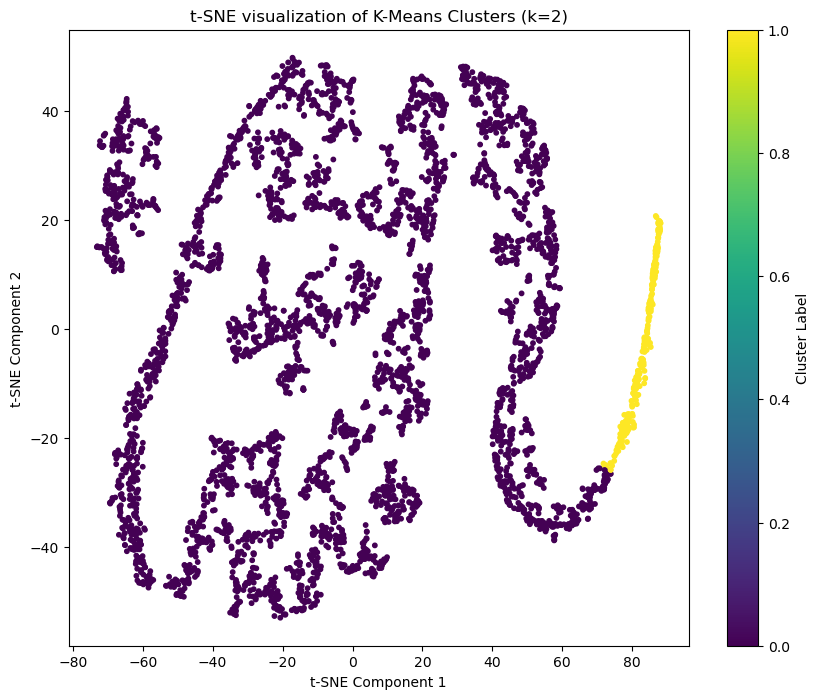

In [114]:
# Visualize Clusters with t-SNE

# Visualize for k=2
plt.figure(figsize=(10, 8))
plt.scatter(embed[:, 0], embed[:, 1], c=result['k=2_cluster_label'], cmap='viridis', s=10)
plt.title('t-SNE visualization of K-Means Clusters (k=2)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster Label')
plt.show()





This is a "map" of your customers. The purple group is the main segment (lower balance, blue-collar), and the yellow group is the premium segment (higher balance, managers). The clear gap confirms they are different enough to treat as separate segments for marketing and product strategies.

**Bottom line:** The visualization confirms your two-segment strategy is valid and actionable.

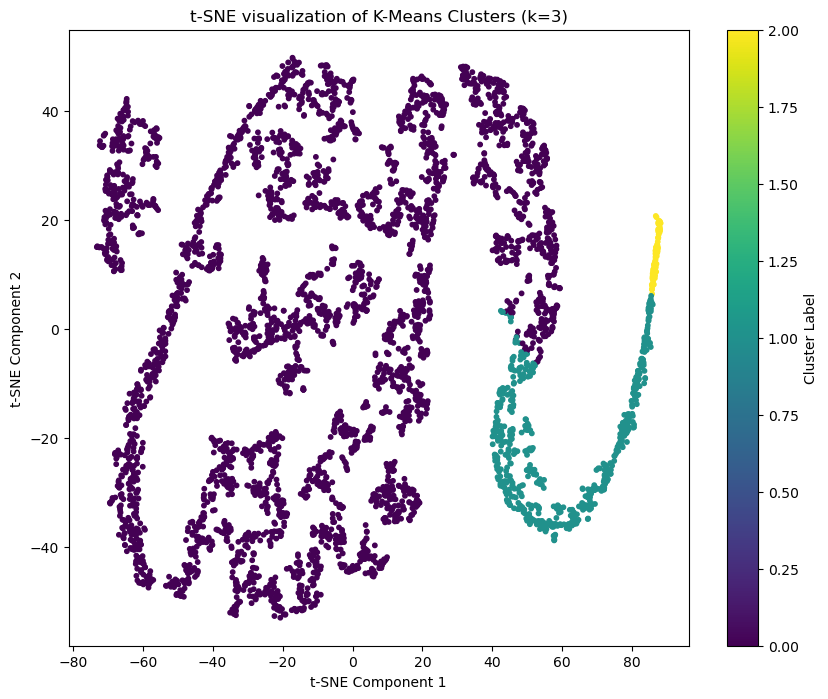

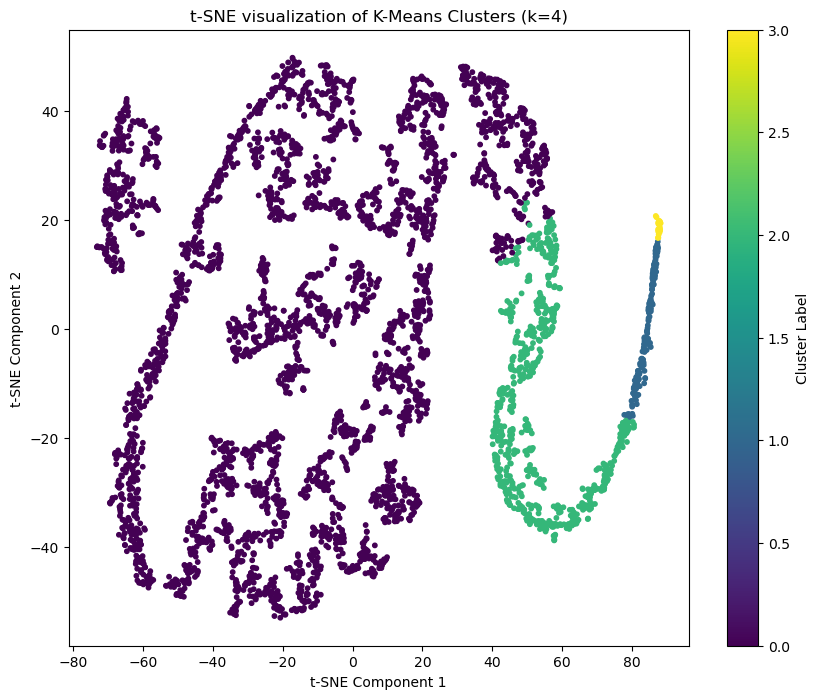

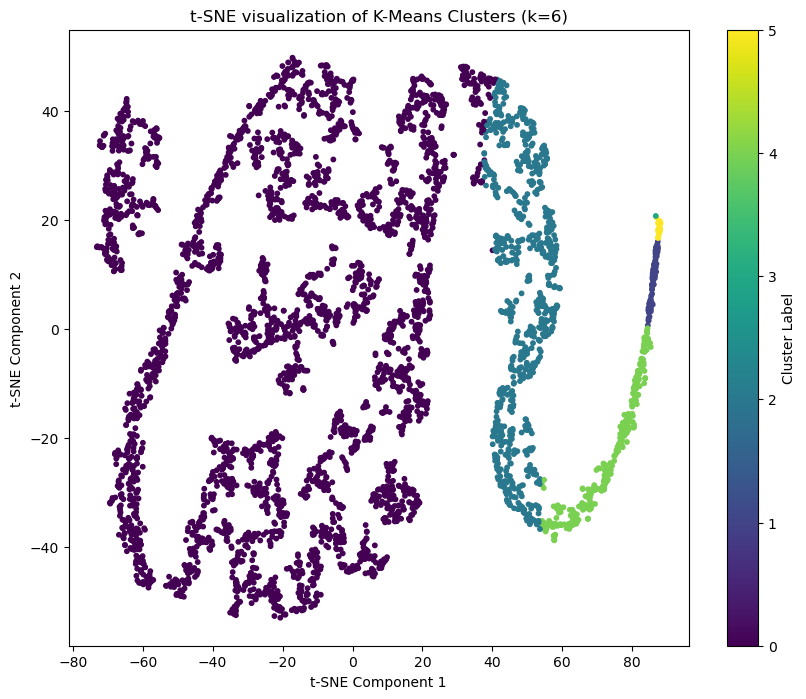

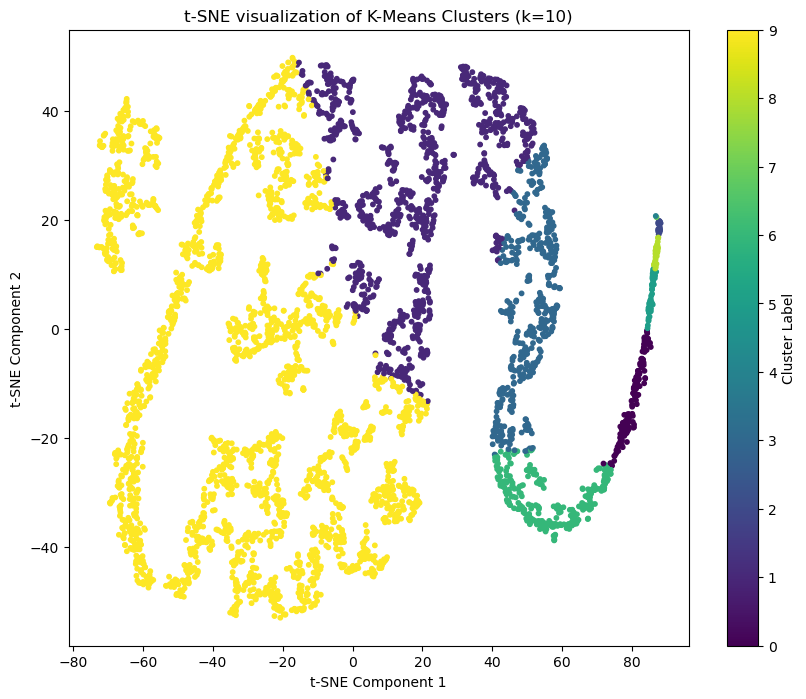

In [115]:
# Visualize for k=3
plt.figure(figsize=(10, 8))
plt.scatter(embed[:, 0], embed[:, 1], c=result['k=3_cluster_label'], cmap='viridis', s=10)
plt.title('t-SNE visualization of K-Means Clusters (k=3)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


# Visualize for k=4
plt.figure(figsize=(10, 8))
plt.scatter(embed[:, 0], embed[:, 1], c=result['k=4_cluster_label'], cmap='viridis', s=10)
plt.title('t-SNE visualization of K-Means Clusters (k=4)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

# Visualize for k=6
plt.figure(figsize=(10, 8))
plt.scatter(embed[:, 0], embed[:, 1], c=result['k=6_cluster_label'], cmap='viridis', s=10)
plt.title('t-SNE visualization of K-Means Clusters (k=6)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

# Visualize for k=10
plt.figure(figsize=(10, 8))
plt.scatter(embed[:, 0], embed[:, 1], c=result['k=10_cluster_label'], cmap='viridis', s=10)
plt.title('t-SNE visualization of K-Means Clusters (k=10)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

## t-SNE Visualization Summary

### Key Finding
All visualizations show the same underlying structure: **two main customer segments** (mainstream on left, high-value on right).

### K=2 (Best: Silhouette 0.8323)
- **Two clear segments** with wide separation
- **Business meaning**: Mainstream customers (purple) vs High-value customers (yellow)

### K=3, 4, 6 (Good Quality)
- Same two-segment structure, but high-value segment splits into sub-tiers
- **K=3**: 2 tiers within high-value segment
- **K=4**: 3 tiers within high-value segment  
- **K=6**: 5 tiers forming a value progression

### K=10 (Over-Segmented)
- Too many clusters, loses clarity
- Artificial subdivisions

### Recommendation
- **Use K=2** for strategic decisions (two main segments)
- **Use K=3-4** for granular targeting within high-value segment
- **Avoid K=10** (too complex, lower quality)